# **First part**

In [ ]:
import numpy as np
from scipy import signal
import cv2
from functools import partial
import matplotlib.pyplot as plt

In [ ]:
def lucas_kanade(img1, img2, window):

  # calculate gradients along x direction
  filter_x = np.transpose(np.array([[-1., -1.], [1., 1.]]))
  I_x1 = signal.convolve2d(img1, filter_x,mode='same')
  I_x2 = signal.convolve2d(img2, filter_x,mode='same')
  Ix = I_x1 + I_x2

  # calculate gradients along y direction
  filter_y = np.array([[-1., -1.], [1., 1.]])
  I_y1 = signal.convolve2d(img1, filter_y, mode = 'same')
  I_y2 = signal.convolve2d(img2, filter_y, mode = 'same')
  Iy = I_y1 + I_y2

  # calculate gradient along t direction
  filter_t1 = np.array([[-1., -1.], [-1., -1.]])
  I_t1 = signal.convolve2d(img1, filter_t1, mode ='same')
  filter_t2 = np.array([[1., 1.], [1., 1.]])
  I_t2 = signal.convolve2d(img2, filter_t2, mode ='same')
  It = I_t1 + I_t2

  u = np.zeros(img1.shape)
  v = np.zeros(img1.shape)

  # solve by assuming that optical flow is constant in a given window size centered on each pixel
  for i in range(1, u.shape[0]):
      for j in range(1, u.shape[1]):
          I_x = Ix[i - (window//2):i + (window//2)+1, j - (window//2):j + (window//2)+1].flatten()
          I_y = Iy[i - (window//2):i + (window//2)+1, j - (window//2):j + (window//2)+1].flatten()
          I_t = It[i - (window//2):i + (window//2)+1, j - (window//2):j + (window//2)+1].flatten()
          A = np.vstack((I_x , I_y)).T
          res = np.matmul(np.matmul(np.linalg.pinv(np.matmul(A.T, A)), A.T), I_t)
          u[i, j] = res[0]
          v[i, j] = res[1]
  return u, v

ls = np.load("GT1.npy")
# Here we are reading the file and converting into the GRAY format
img1 = cv2.imread("img1.jpg")
img2 = cv2.imread("img2.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#Take window size as input
window=int(input("Enter the window size: "))
u,v=lucas_kanade(img1,img2,window)

#Calculating MSE
mse=0
for i in range(img1.shape[0]):
  for  j in range(img1.shape[1]):
    mse=mse+(((u[i][j]**2+v[i][j]**2) **0.5 - ls[i][j]) **2 / (img1.shape[0]*img1.shape[1]))
print(mse)



Enter the window size: 15
73.47709846144896


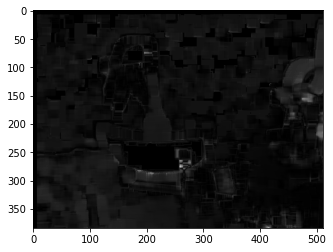

In [ ]:
plt.imshow((u**2+v**2)**0.5,cmap='gray')

# **Observation:**
As we are increasing the window size the MSE is Increasing.This is beacause
In Lucas Kanade algorithm we have assumed that optical flow in that particular
window is constant.So the more we increase the window size the less accurate it will be to assume optical flow to be constant in that window.So the MSE is increasing as we increase the window size.


# **Second part**

**Exhaustive search**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Here we are reading the file and converting into the GRAY format
d1= np.load('GT1.npy')
img1r = cv2.imread('img1.jpg',cv2.IMREAD_GRAYSCALE).astype(np.float32)
img1p = cv2.imread('img2.jpg',cv2.IMREAD_GRAYSCALE).astype(np.float32)



In [ ]:
# Set the block size and search range
block_size = 4
window_size = 8


# Compute the maximum displacement allowed within the search window
max_disp = (window_size - block_size)

# Initialize an array to store the estimated flow vectors
est_flow = np.zeros_like(d1)

# Iterate over each block in the current frame
for y in range(0, img1r.shape[0] - block_size + 1, block_size):
    for x in range(0, img1r.shape[1] - block_size + 1, block_size):

        # Initialize the minimum error and displacement
        min_error = float('inf')
        min_disp = (0, 0)

        # Iterate over each possible displacement vector within the search window
        for dy in range(-max_disp, max_disp + 1):
            for dx in range(-max_disp, max_disp + 1):

                # Compute the error between the current block and the corresponding block in the reference frame
                ref_y, ref_x = y + dy, x + dx
                if ref_y >= 0 and ref_x >= 0 and ref_y + block_size <= img1p.shape[0] and ref_x + block_size <= img1p.shape[1]:
                    error = np.sum(np.abs(img1r[y:y+block_size, x:x+block_size] - img1p[ref_y:ref_y+block_size, ref_x:ref_x+block_size]))

                    # Update the minimum error and displacement if the current displacement is better
                    if error < min_error:
                        min_error = error
                        min_disp = np.sqrt(dx**2+ dy**2)

        # Store the estimated flow vector for the current block
        est_flow[y:y+block_size, x:x+block_size] += min_disp


In [ ]:
np.mean(np.square(est_flow-d1))

61.875824

In [ ]:
cv2.imshow

**Implimentation of Three step search**

In [ ]:
block_size = 4 # Block size (assuming square blocks)
window_size = 16 # Search window size (assuming square windows)
step_size = 8 # Search step size (for three-step and diamond search)

In [ ]:
# Compute the maximum displacement allowed within the search window
max_disp = (window_size - block_size)

# Initialize an array to store the estimated flow vectors
est_flow = np.zeros_like(d1)

# Iterate over each block in the current frame
for y in range(0, img1r.shape[0] - block_size + 1, block_size):
    for x in range(0, img1r.shape[1] - block_size + 1, block_size):

        # Initialize the minimum error and displacement
        min_error = float('inf')
        min_disp = (0, 0)

        # Iterate over each possible displacement vector within the search window, using a three
        for step in [step_size, step_size // 2, step_size // 4]:
            # Iterate over each possible displacement vector within the current step
            for dy in range(-step, step + 1, step):
                for dx in range(-step, step + 1, step):

                    # Compute the error between the current block and the corresponding block in the reference frame
                    ref_y, ref_x = y + min_disp[1] + dy, x + min_disp[0] + dx
                    if ref_y >= 0 and ref_x >= 0 and ref_y + block_size <= img1p.shape[0] and ref_x + block_size <= img1p.shape[1]:
                        error = np.sum(np.abs(img1r[y:y+block_size, x:x+block_size] - img1p[ref_y:ref_y+block_size, ref_x:ref_x+block_size]))

                        # Update the minimum error and displacement if the current displacement is better
                        if error < min_error:
                            min_error = error
                            min_disp = (min_disp[0] + dx, min_disp[1] + dy)

        # Store the estimated flow vector for the current block
        est_flow[y:y+block_size, x:x+block_size] += np.sqrt(min_disp[0]**2+min_disp[1]**2)


In [ ]:
np.mean(np.square(est_flow-d1))

**Implimentation of Diamond Search**

In [ ]:
block_size = 4 # Block size (assuming square blocks)
window_size = 16 # Search window size (assuming square windows)
step_size = 8 # Search step size (for three-step and diamond search)

est_flow = np.zeros_like(d1)
for y in range(0, img1r.shape[0] - block_size + 1, block_size):
    for x in range(0, img1r.shape[1] - block_size + 1, block_size):

        # in strings to escape characters //
        cx, cy = (window_size - block_size) // 2, (window_size - block_size) // 2
        step = (window_size - block_size) // 2
        while step >= step_size:
            min_error = float('inf')
            min_disp = (0, 0)
            for dx, dy in [(0, -step), (0, step), (-step, 0), (step, 0)]:
                ref_y, ref_x = y + cy + dy, x + cx + dx
                if ref_y >= 0 and ref_x >= 0 and ref_y + block_size <= img1p.shape[0] and ref_x + block_size <= img1p.shape[1]:
                    error = np.sum(np.abs(img1r[y:y+block_size, x:x+block_size] - img1p[ref_y:ref_y+block_size, ref_x:ref_x+block_size]))
                    if error < min_error:
                        min_error = error
                        min_disp = (dx, dy)
            cx += min_disp[0]
            cy += min_disp[1]
            step //= 2
        min_error = float('inf')
        min_disp = (0, 0)
        for dy in range(-step_size, step_size + 1, step_size):
            for dx in range(-step_size, step_size + 1, step_size):
                ref_y, ref_x = y + cy + dy, x + cx + dx
                if ref_y >= 0 and ref_x >= 0 and ref_y + block_size <= img1p.shape[0] and ref_x + block_size <= img1p.shape[1]:
                    error = np.sum(np.abs(img1r[y:y+block_size, x:x+block_size] - img1p[ref_y:ref_y+block_size, ref_x:ref_x+block_size]))
                    if error < min_error:
                        min_error = error
                        min_disp = (cx + dx, cy + dy)
        est_flow[y:y+block_size, x:x+block_size] = np.sqrt(min_disp[0]**2+min_disp[1]**2)


np.mean(np.square(est_flow-d1))


72.58007

Setting the parameters and padding so that motion vector for boundary pixel can be calculated

In [ ]:
# Here we are reading the file and converting into the YCbCr format
img1 = cv2.imread("img1.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2YCR_CB)[:,:,0]
img2 = cv2.imread("img2.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2YCR_CB)[:,:,0]
height, width = img1.shape
window = int(input("window size for calculating the cost: Hint: choose 7 or 3\n"))
window = window//2

# here we could be required max padding of size window + search_step + search_step/2 + search_step/4.....1

search_step = 4
padsearch = search_step
padding = window

while padsearch:
  padding = padding + padsearch
  padsearch = padsearch//2

top, bottom, left, right =(padding, padding, padding, padding)
image1 = cv2.copyMakeBorder(img1, top, bottom, left, right, cv2.BORDER_REPLICATE)
image2 = cv2.copyMakeBorder(img2, top, bottom, left, right, cv2.BORDER_REPLICATE)

max_range = height+2*padding, width+2*padding
search_area = partial(search, max_coord=max_range)

window size for calculating the cost: Hint: choose 7 or 3
7


In [ ]:
def search_helper(searching_alog, preframe, currentframe, search_step, window, cost_function):
  # all_motion = np.array((height+padding, width+padding))
  all_motion = []
  global min_location
  for i in range(padding-1, height+padding-1):
      temp = []
      for j in range(padding-1, width+padding-1):
        location = np.array([i, j])
        min_location = []
        temp.append(location - searching_alog(preframe, currentframe, location, search_step, window, cost_function))
      all_motion.append(temp)
  return all_motion

In [ ]:
# To call the diamond_search algorithm for all the points in the image use the below code
motion_vectors2 = search_helper(diamond_search, image1, image2, 4, window, mse_cost)

In [ ]:
motion_vectors2=np.array(motion_vectors2)
plt.imshow((motion_vectors2[:,:,0]**2+motion_vectors2[:,:,1]**2)**.5)

NameError: ignored

In [ ]:
motion_vectors2

array([[[ 20, -20],
        [ 20, -20],
        [ 20, -20],
        ...,
        [ 20, -20],
        [ 20, -20],
        [ 20, -20]],

       [[ 20, -20],
        [ 20, -20],
        [ 20, -20],
        ...,
        [ 20, -20],
        [ 20, -20],
        [ 20, -20]],

       [[ 20, -20],
        [ 20, -20],
        [ 20, -20],
        ...,
        [ 20, -20],
        [ 20, -20],
        [ 20, -20]],

       ...,

       [[ 20, -20],
        [ 20, -20],
        [ 20, -20],
        ...,
        [ 20, -20],
        [ 20, -20],
        [ 20, -20]],

       [[ 20, -20],
        [ 20, -20],
        [ 20, -20],
        ...,
        [ 20, -20],
        [ 20, -20],
        [ 20, -20]],

       [[ 20, -20],
        [ 20, -20],
        [ 20, -20],
        ...,
        [ 20, -20],
        [ 20, -20],
        [ 20, -20]]])

In [ ]:
# To call the three step search algorithm for all the points in the image use the below code
motion_vectors1 = search_helper(three_step_search, image1, image2, window, 4, mse_cost)

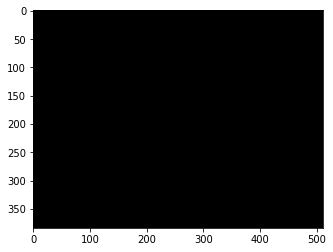

In [ ]:
motion_vectors1=np.array(motion_vectors1)
plt.imshow((motion_vectors2[:,:,0]**2+motion_vectors2[:,:,1]**2)**.5, cmap='gray')

In [ ]:
motion_vectors1

array([[[ 3,  0],
        [ 3,  0],
        [ 0,  0],
        ...,
        [ 0,  0],
        [ 0,  0],
        [ 0,  0]],

       [[ 0,  0],
        [ 0,  0],
        [ 0,  0],
        ...,
        [ 0,  0],
        [ 0,  0],
        [ 0,  0]],

       [[ 0,  0],
        [ 0,  0],
        [ 0,  0],
        ...,
        [ 0,  0],
        [ 0,  0],
        [ 0,  0]],

       ...,

       [[ 3,  0],
        [ 3,  3],
        [ 3,  3],
        ...,
        [ 0,  0],
        [ 0,  0],
        [ 3,  0]],

       [[ 3,  3],
        [ 3, -3],
        [ 3, -3],
        ...,
        [ 0,  0],
        [ 0,  0],
        [ 3,  0]],

       [[ 3, -3],
        [ 3, -3],
        [ 3, -3],
        ...,
        [ 0,  0],
        [ 0,  0],
        [ 3,  0]]])